In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pos-1m-clean/1M_pos_clean_data.npy


In [2]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd

In [3]:
data = np.load('/kaggle/input/pos-1m-clean/1M_pos_clean_data.npy')
data.shape

(995978, 279)

In [4]:
test_ind = [1,10,100]
new_data = np.delete(data,test_ind,axis=0)
new_data.shape

(995975, 279)

In [5]:
train_data = new_data
new_spec = np.zeros_like(train_data[:,:274])
for i in range(len(train_data)):
    mean_sp = np.mean(train_data[i,:269])
    std_sp = np.std(train_data[i,:269])
    new_spec[i,:269] = (train_data[i,:269] - mean_sp) / std_sp
    new_spec[i,269] = mean_sp
    new_spec[i,270] = std_sp
    new_spec[i,271] = train_data[i,269]   # rstar
    new_spec[i,272] = train_data[i,270]   # rplanet
    new_spec[i,273] = train_data[i,271]   # gp
new_spec.shape

(995975, 274)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR

class LSTMModel(nn.Module):
    def __init__(self ):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=X_train.shape[1], hidden_size=64, batch_first=True)
        self.lstm2 = nn.LSTM(64, hidden_size=128, num_layers=1, 
                            bidirectional=False, batch_first=True)
        self.lstm3 = nn.LSTM(128, hidden_size=256, num_layers=1, 
                            bidirectional=False, batch_first=True)
        self.lstm4 = nn.LSTM(256, hidden_size=128, num_layers=1, 
                            bidirectional=False, batch_first=True)
        self.dense = nn.Linear(128, 7)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x, _ = self.lstm4(x)
        x = self.dense(x)
        return x

# Define the R^2 loss function
class R2Loss(nn.Module):
    def __init__(self):
        super(R2Loss, self).__init__()

    def forward(self, y_pred, y_true):
        ss_res = torch.sum(torch.square(y_true - y_pred))
        ss_tot = torch.sum(torch.square(y_true - torch.mean(y_true)))
        r2 = 1 - ss_res / ss_tot
        return r2

## 10k Data

In [7]:
X = new_spec[:10000]
Y = new_data[:10000,272:]
X.shape, Y.shape

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Y = scaler.fit_transform(Y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 274), (2000, 274), (8000, 7), (2000, 7))

In [8]:
initial_learning_rate = 1e-4
final_learning_rate = 1e-6
epochs = 100
train_size = X_train.shape[0]
batch_size = 32
lr_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)
lr_decay_factor, steps_per_epoch

(0.954992586021436, 250)

In [9]:
# Define the neural network
net_10k = LSTMModel()

input_size = (1,X_train.shape[1])
summary(net_10k, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [1, 7]                    --
├─LSTM: 1-1                              [1, 64]                   87,040
├─LSTM: 1-2                              [1, 128]                  99,328
├─LSTM: 1-3                              [1, 256]                  395,264
├─LSTM: 1-4                              [1, 128]                  197,632
├─Linear: 1-5                            [1, 7]                    903
Total params: 780,167
Trainable params: 780,167
Non-trainable params: 0
Total mult-adds (M): 144.77
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 3.12
Estimated Total Size (MB): 3.13

Epoch 1 loss: 0.998 R^2: -0.004 test_loss: 1.001 test_R^2: 0.005  
Epoch 2 loss: 0.899 R^2: 0.095 test_loss: 0.789 test_R^2: 0.215  
Epoch 3 loss: 0.747 R^2: 0.249 test_loss: 0.680 test_R^2: 0.323  
Epoch 4 loss: 0.653 R^2: 0.344 test_loss: 0.626 test_R^2: 0.378  
Epoch 5 loss: 0.582 R^2: 0.415 test_loss: 0.548 test_R^2: 0.455  
Epoch 6 loss: 0.526 R^2: 0.471 test_loss: 0.509 test_R^2: 0.494  
Epoch 7 loss: 0.482 R^2: 0.515 test_loss: 0.457 test_R^2: 0.545  
Epoch 8 loss: 0.436 R^2: 0.561 test_loss: 0.432 test_R^2: 0.570  
Epoch 9 loss: 0.417 R^2: 0.580 test_loss: 0.418 test_R^2: 0.584  
Epoch 10 loss: 0.406 R^2: 0.592 test_loss: 0.410 test_R^2: 0.593  
Epoch 11 loss: 0.398 R^2: 0.600 test_loss: 0.404 test_R^2: 0.598  
Epoch 12 loss: 0.392 R^2: 0.606 test_loss: 0.398 test_R^2: 0.604  
Epoch 13 loss: 0.388 R^2: 0.610 test_loss: 0.398 test_R^2: 0.604  
Epoch 14 loss: 0.384 R^2: 0.614 test_loss: 0.391 test_R^2: 0.611  
Epoch 15 loss: 0.379 R^2: 0.619 test_loss: 0.388 test_R^2: 0.614  
Epo

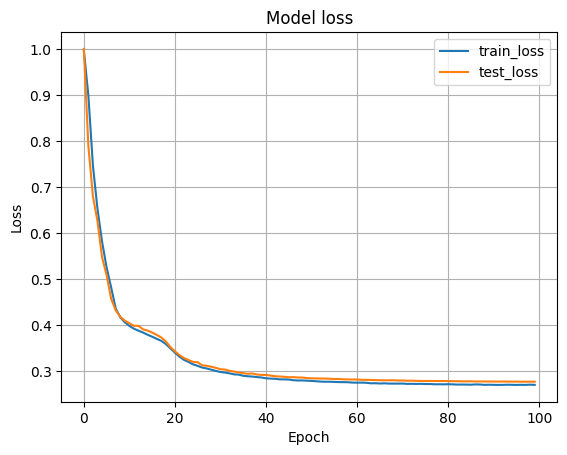

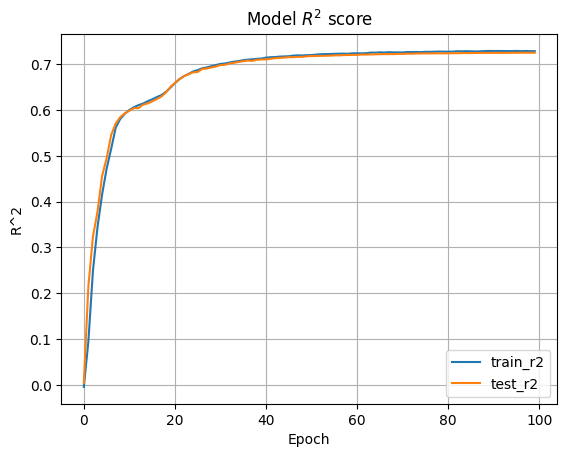

In [10]:
# Define the data
data = X_train
labels = y_train

# Convert the data to PyTorch tensors
data = torch.from_numpy(data).float()
labels = torch.from_numpy(labels).float()

# Define the data loader
trainset = torch.utils.data.TensorDataset(data, labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net_10k.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer,gamma=lr_decay_factor)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the neural network

epochs = 100

net_10k.to(device)
losses = []
r2s = []
test_losses = []
test_r2s = []
cur_lrs =[]
for epoch in range(epochs):
    net_10k.train()
    running_loss = 0.0
    running_r2 = 0.0
    for i, data in enumerate(trainloader, 0):
        
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net_10k(inputs)
        loss = criterion(outputs, labels)
        r2 = R2Loss()(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_r2 += r2.item()
    losses.append(running_loss / len(trainloader))
    r2s.append(running_r2 / len(trainloader))
#         print('Epoch %d loss: %.3f R^2: %.3f' % (epoch + 1, running_loss / len(trainloader), running_r2 / len(trainloader)))
    # Test the neural network on the test data
    test_data = X_test
    test_labels = y_test
    test_data = torch.from_numpy(test_data).float()
    test_labels = torch.from_numpy(test_labels).float()
    net_10k.eval()
    with torch.no_grad():
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        test_outputs = net_10k(test_data)
        test_loss = criterion(test_outputs, test_labels)
        test_r2 = R2Loss()(test_outputs, test_labels)
        test_losses.append(test_loss.item())
        test_r2s.append(test_r2.item())
    current_lr = optimizer.param_groups[0]['lr']
    cur_lrs.append(current_lr)
    print('Epoch %d loss: %.3f R^2: %.3f test_loss: %.3f test_R^2: %.3f  ' % (epoch + 1, running_loss / len(trainloader), running_r2 / len(trainloader), test_loss, test_r2))    
    scheduler.step()
    
# plotting model loss    
plt.plot(losses,label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend()
plt.grid()
plt.show()
# plotting model r2 score
plt.plot(r2s, label='train_r2')
plt.plot(test_r2s, label='test_r2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.title('Model $R^{2}$ score')
plt.legend()
plt.grid()
plt.show()

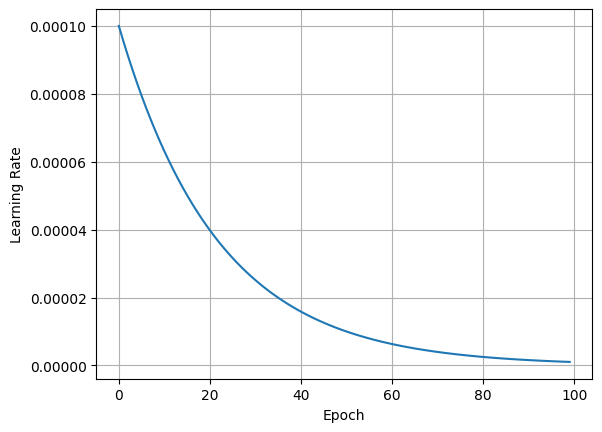

In [11]:
plt.plot( cur_lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid()
plt.show()

In [12]:
path = '/kaggle/working/lstm_10k_m_s_p'
torch.save(net_10k,path)

In [13]:
with torch.no_grad():
    test_data, test_labels = test_data.to(device), test_labels.to(device)
    test_outputs = net_10k(test_data)    
    pred = test_outputs
pred.shape

torch.Size([2000, 7])

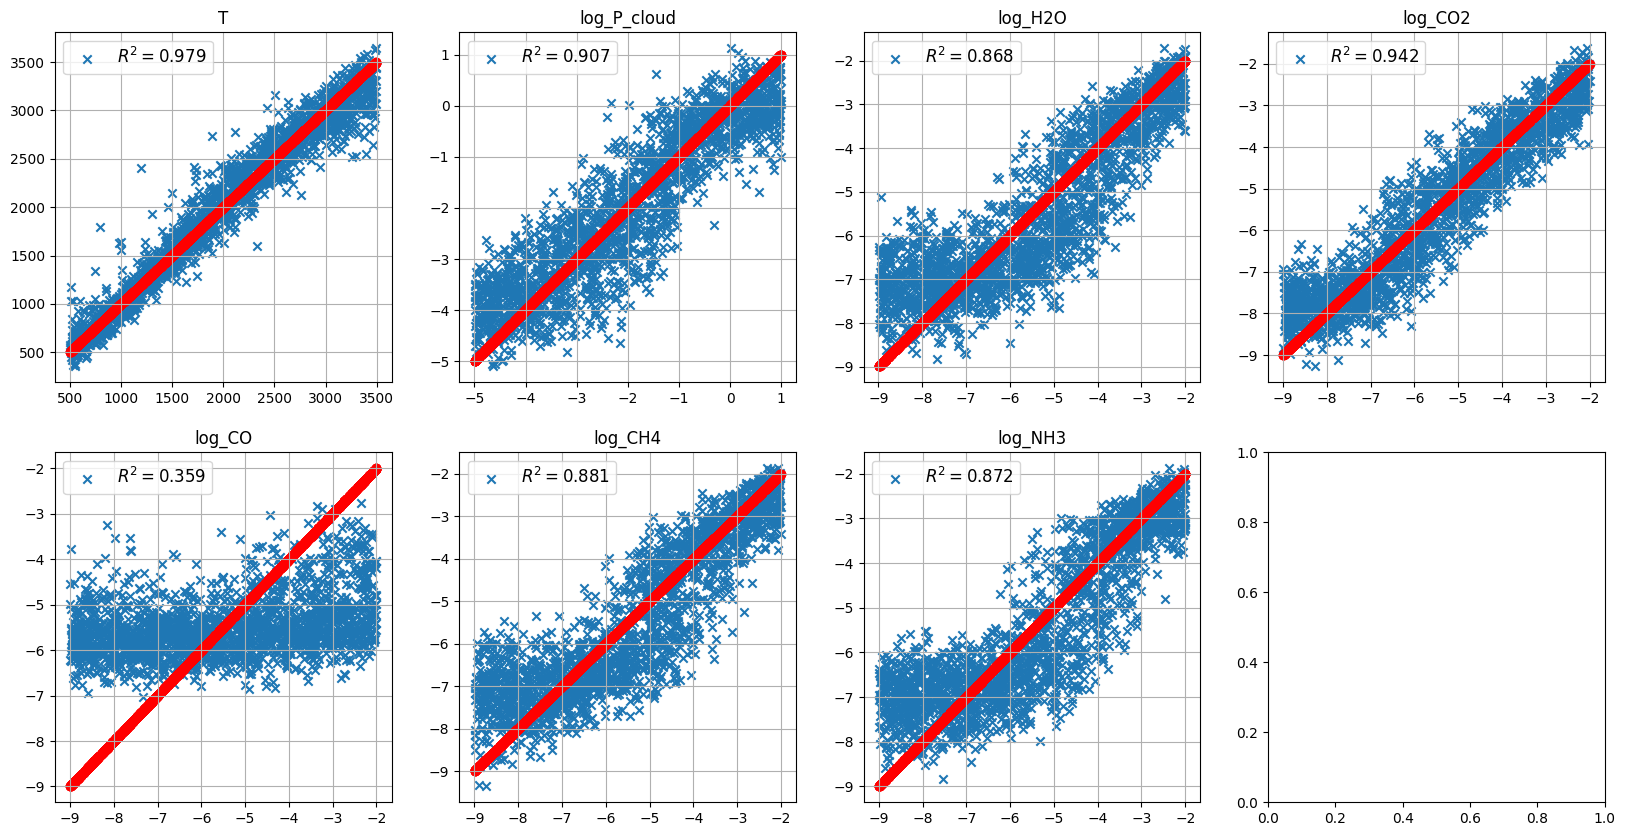

In [14]:
from scipy.stats import pearsonr

keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = np.array(pred.cpu())
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[0,i].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[1,i-4].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

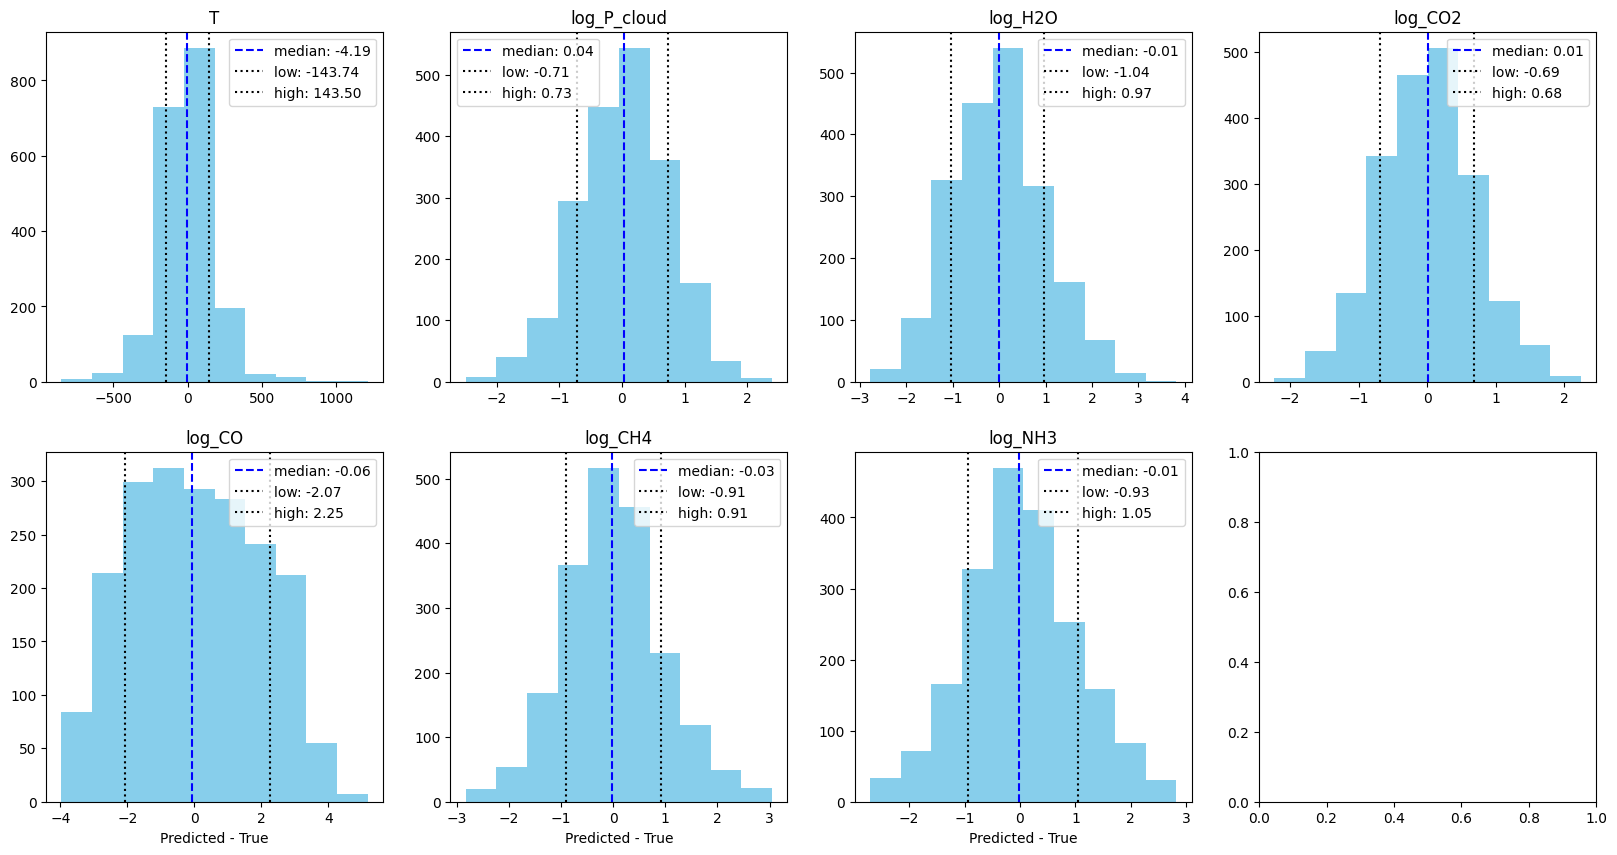

In [15]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = np.array(pred.cpu())
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[0,i].hist(pred_err,bins=10,color='skyblue')
        axs[0,i].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[0,i].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[0,i].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[1,i-4].hist(pred_err,bins=10,color='skyblue')
        axs[1,i-4].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[1,i-4].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[1,i-4].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')

In [16]:
y_test_rescaled_10k = scaler.inverse_transform(y_test)
predictions_10k = np.array(pred.cpu())
predictions_10k = scaler.inverse_transform(predictions_10k)

## Testing on the retreived planets

In [17]:
file_data = np.load('/kaggle/input/pos-1m-clean/1M_pos_clean_data.npy')

In [18]:
mean = np.mean(file_data[1,:269])
std = np.std(file_data[1,:269])
planetA_spec = (file_data[1,:269] - mean) / std
FH = np.max(file_data[1,:269]) - np.min(file_data[1,:269])
# planetA_spec = np.concatenate([planetA_spec,np.array([mean]),np.array([std])])
planetA_spec = np.concatenate([planetA_spec,np.array([mean]),np.array([std]),np.array([file_data[1,269]]), np.array([file_data[1,270]]), np.array([file_data[1,271]])])
planetA_params = file_data[1,269:]
planetA_spec.shape, planetA_params.shape

((274,), (10,))

In [19]:
mean = np.mean(file_data[10,:269])
std = np.std(file_data[10,:269])
planetB_spec = (file_data[10,:269] - mean) / std
FH = np.max(file_data[10,:269]) - np.min(file_data[10,:269])
# planetB_spec = np.concatenate([planetB_spec,np.array([mean]),np.array([std])])
planetB_spec = np.concatenate([planetB_spec,np.array([mean]),np.array([std]),np.array([file_data[10,269]]), np.array([file_data[10,270]]), np.array([file_data[10,271]])])
planetB_params = file_data[10,269:]
planetB_spec.shape, planetB_params.shape

((274,), (10,))

In [20]:
mean = np.mean(file_data[100,:269])
std = np.std(file_data[100,:269])
planetC_spec = (file_data[100,:269] - mean) / std
FH = np.max(file_data[100,:269]) - np.min(file_data[100,:269])
# planetC_spec = np.concatenate([planetC_spec,np.array([mean]),np.array([std])])
planetC_spec = np.concatenate([planetC_spec,np.array([mean]),np.array([std]),np.array([file_data[100,269]]), np.array([file_data[100,270]]), np.array([file_data[100,271]])])
planetC_params = file_data[100,269:]
planetC_spec.shape, planetC_params.shape

((274,), (10,))

In [21]:
test_planets = np.array([planetA_spec,planetB_spec,planetC_spec])
test_planets.shape

(3, 274)

In [22]:
pred_data = torch.from_numpy(test_planets).float()
with torch.no_grad():
    pred_data = pred_data.to(device)
    pred = net_10k(pred_data)    
pred = np.array(pred.cpu())    
pred.shape

(3, 7)

In [23]:
pred = scaler.inverse_transform(pred)
pred

array([[ 2.2062512e+03, -1.0139798e+00, -6.7815995e+00, -7.7951350e+00,
        -5.4058099e+00, -3.0322957e+00, -3.9807169e+00],
       [ 1.1504189e+03,  1.6999167e-01, -2.4823532e+00, -2.5882618e+00,
        -5.6626744e+00, -6.4395704e+00, -5.3821192e+00],
       [ 2.4588743e+03, -3.6618104e+00, -6.5439439e+00, -4.7256894e+00,
        -6.3867416e+00, -2.3881180e+00, -6.1827374e+00]], dtype=float32)

In [24]:
planetA_pred_10k = pred[0]
print("Predicted values:",planetA_pred_10k)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.2062512e+03 -1.0139798e+00 -6.7815995e+00 -7.7951350e+00
 -5.4058099e+00 -3.0322957e+00 -3.9807169e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


In [25]:
planetB_pred_10k = pred[1]
print("Predicted values:",planetB_pred_10k)
print("Actual values:",planetB_params[3:])

Predicted values: [ 1.1504189e+03  1.6999167e-01 -2.4823532e+00 -2.5882618e+00
 -5.6626744e+00 -6.4395704e+00 -5.3821192e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


In [26]:
planetC_pred_10k = pred[2]
print("Predicted values:",planetC_pred_10k)
print("Actual values:",planetC_params[3:])

Predicted values: [ 2.4588743e+03 -3.6618104e+00 -6.5439439e+00 -4.7256894e+00
 -6.3867416e+00 -2.3881180e+00 -6.1827374e+00]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


## 100k data

In [27]:
X = new_spec[:100000]
Y = new_data[:100000,272:]
X.shape, Y.shape

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Y = scaler.fit_transform(Y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 274), (20000, 274), (80000, 7), (20000, 7))

In [28]:
initial_learning_rate = 1e-4
final_learning_rate = 1e-6
epochs = 100
train_size = X_train.shape[0]
batch_size = 32
lr_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)
lr_decay_factor, steps_per_epoch

(0.954992586021436, 2500)

In [29]:
# Define the neural network
net_100k = LSTMModel()

input_size = (1,X_train.shape[1])
summary(net_100k, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [1, 7]                    --
├─LSTM: 1-1                              [1, 64]                   87,040
├─LSTM: 1-2                              [1, 128]                  99,328
├─LSTM: 1-3                              [1, 256]                  395,264
├─LSTM: 1-4                              [1, 128]                  197,632
├─Linear: 1-5                            [1, 7]                    903
Total params: 780,167
Trainable params: 780,167
Non-trainable params: 0
Total mult-adds (M): 144.77
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 3.12
Estimated Total Size (MB): 3.13

Epoch 1 loss: 0.635 R^2: 0.363 test_loss: 0.397 test_R^2: 0.602  
Epoch 2 loss: 0.334 R^2: 0.665 test_loss: 0.289 test_R^2: 0.711  
Epoch 3 loss: 0.277 R^2: 0.722 test_loss: 0.265 test_R^2: 0.734  
Epoch 4 loss: 0.251 R^2: 0.748 test_loss: 0.236 test_R^2: 0.763  
Epoch 5 loss: 0.219 R^2: 0.780 test_loss: 0.199 test_R^2: 0.801  
Epoch 6 loss: 0.188 R^2: 0.811 test_loss: 0.175 test_R^2: 0.825  
Epoch 7 loss: 0.166 R^2: 0.833 test_loss: 0.155 test_R^2: 0.845  
Epoch 8 loss: 0.152 R^2: 0.848 test_loss: 0.143 test_R^2: 0.857  
Epoch 9 loss: 0.142 R^2: 0.858 test_loss: 0.148 test_R^2: 0.852  
Epoch 10 loss: 0.135 R^2: 0.865 test_loss: 0.135 test_R^2: 0.865  
Epoch 11 loss: 0.128 R^2: 0.871 test_loss: 0.131 test_R^2: 0.869  
Epoch 12 loss: 0.123 R^2: 0.876 test_loss: 0.120 test_R^2: 0.880  
Epoch 13 loss: 0.119 R^2: 0.880 test_loss: 0.126 test_R^2: 0.874  
Epoch 14 loss: 0.116 R^2: 0.884 test_loss: 0.116 test_R^2: 0.884  
Epoch 15 loss: 0.112 R^2: 0.887 test_loss: 0.113 test_R^2: 0.887  
Epoc

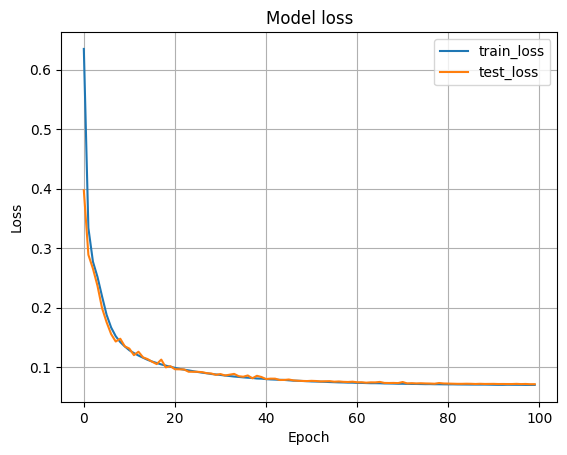

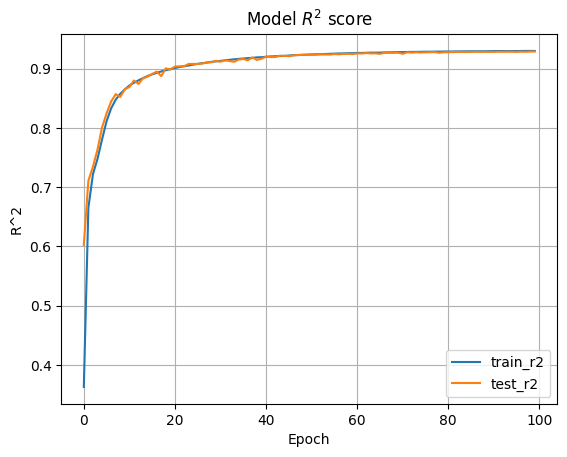

In [30]:
# Define the data
data = X_train
labels = y_train

# Convert the data to PyTorch tensors
data = torch.from_numpy(data).float()
labels = torch.from_numpy(labels).float()

# Define the data loader
trainset = torch.utils.data.TensorDataset(data, labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net_100k.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer,gamma=lr_decay_factor)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the neural network

epochs = 100

net_100k.to(device)
losses = []
r2s = []
test_losses = []
test_r2s = []
cur_lrs =[]
for epoch in range(epochs):
    net_100k.train()
    running_loss = 0.0
    running_r2 = 0.0
    for i, data in enumerate(trainloader, 0):
        
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net_100k(inputs)
        loss = criterion(outputs, labels)
        r2 = R2Loss()(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_r2 += r2.item()
    losses.append(running_loss / len(trainloader))
    r2s.append(running_r2 / len(trainloader))
#         print('Epoch %d loss: %.3f R^2: %.3f' % (epoch + 1, running_loss / len(trainloader), running_r2 / len(trainloader)))
    # Test the neural network on the test data
    test_data = X_test
    test_labels = y_test
    test_data = torch.from_numpy(test_data).float()
    test_labels = torch.from_numpy(test_labels).float()
    net_100k.eval()
    with torch.no_grad():
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        test_outputs = net_100k(test_data)
        test_loss = criterion(test_outputs, test_labels)
        test_r2 = R2Loss()(test_outputs, test_labels)
        test_losses.append(test_loss.item())
        test_r2s.append(test_r2.item())
    current_lr = optimizer.param_groups[0]['lr']
    cur_lrs.append(current_lr)
    print('Epoch %d loss: %.3f R^2: %.3f test_loss: %.3f test_R^2: %.3f  ' % (epoch + 1, running_loss / len(trainloader), running_r2 / len(trainloader), test_loss, test_r2))    
    scheduler.step()
    
# plotting model loss    
plt.plot(losses,label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend()
plt.grid()
plt.show()
# plotting model r2 score
plt.plot(r2s, label='train_r2')
plt.plot(test_r2s, label='test_r2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.title('Model $R^{2}$ score')
plt.legend()
plt.grid()
plt.show()

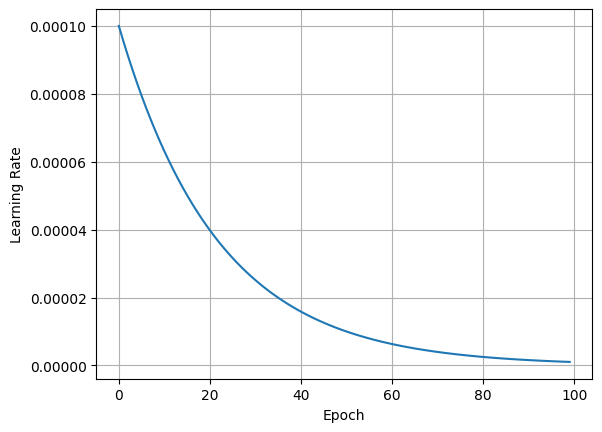

In [31]:
plt.plot( cur_lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid()
plt.show()

In [32]:
path = '/kaggle/working/lstm_100k_m_s_p'
torch.save(net_100k,path)

In [33]:
with torch.no_grad():
    test_data, test_labels = test_data.to(device), test_labels.to(device)
    test_outputs = net_100k(test_data)    
    pred = test_outputs
pred.shape

torch.Size([20000, 7])

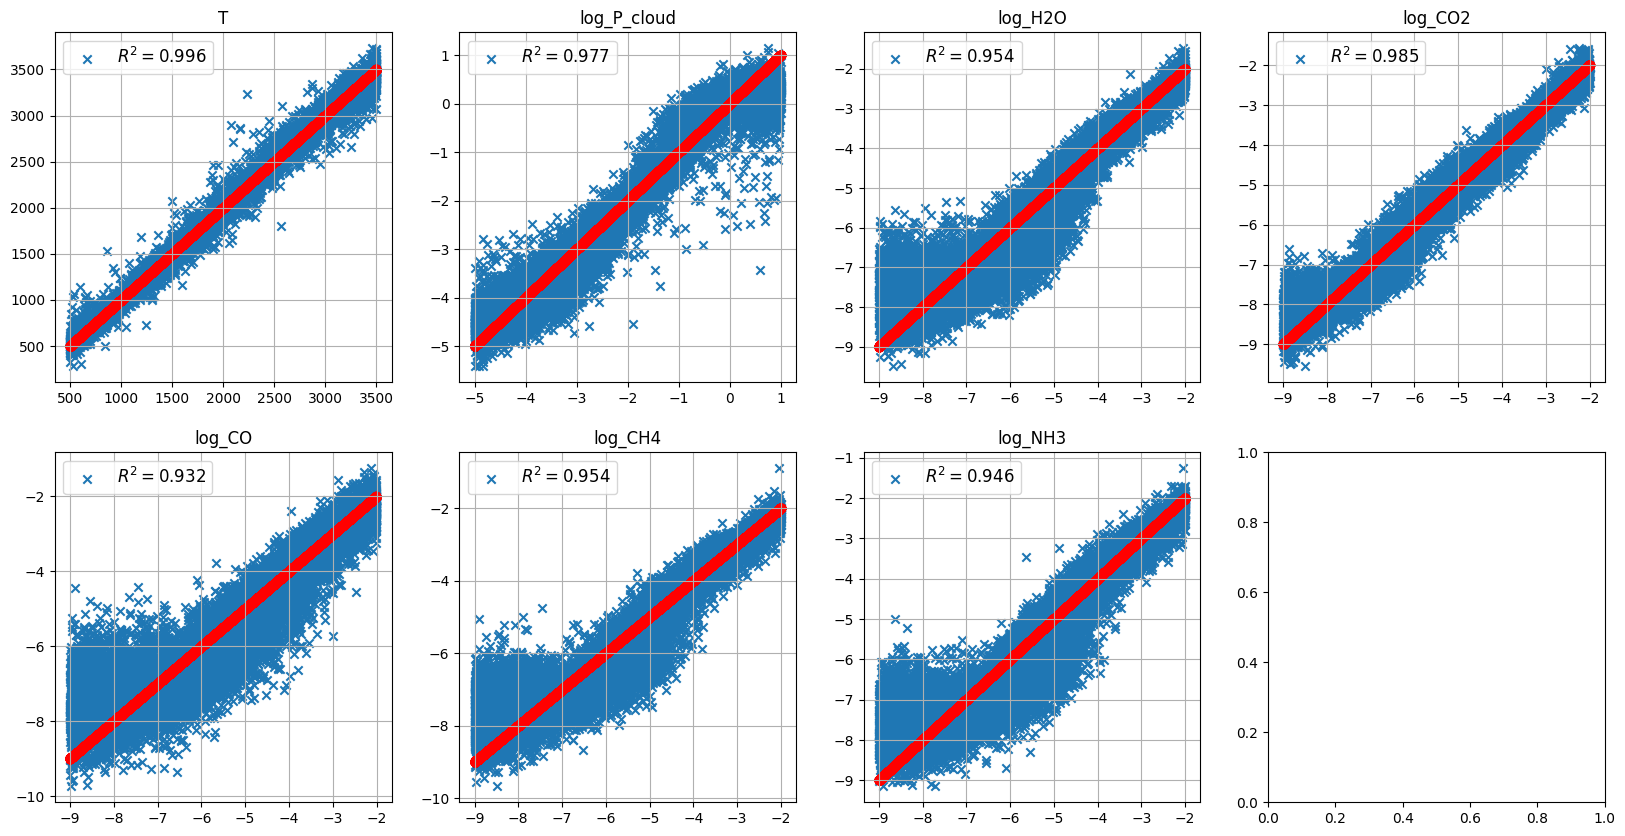

In [34]:
from scipy.stats import pearsonr

keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = np.array(pred.cpu())
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[0,i].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[1,i-4].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

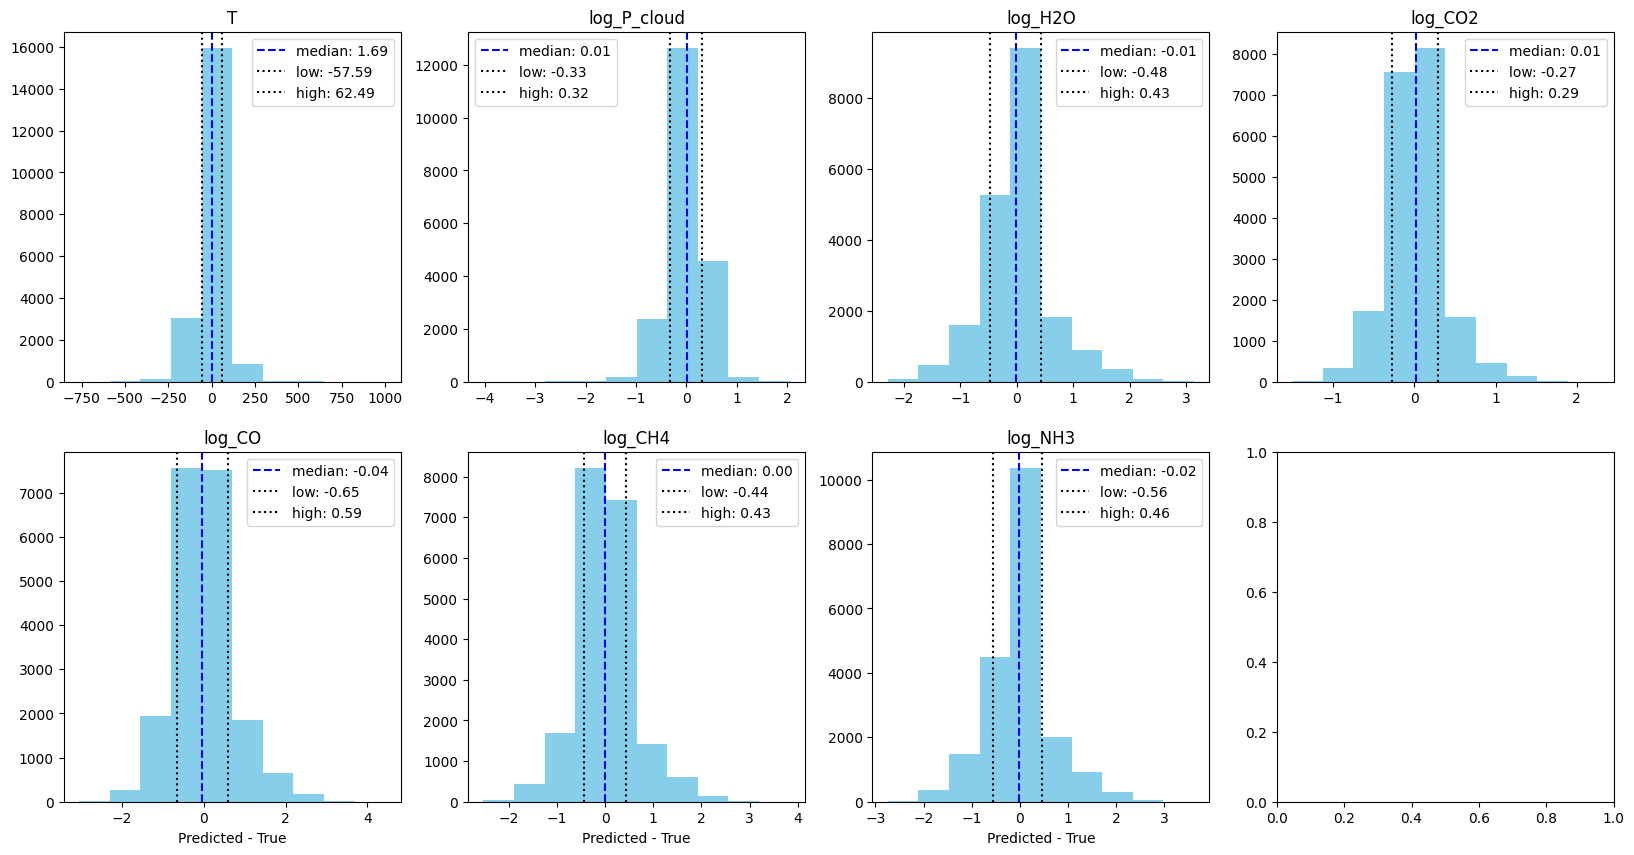

In [35]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = np.array(pred.cpu())
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[0,i].hist(pred_err,bins=10,color='skyblue')
        axs[0,i].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[0,i].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[0,i].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[1,i-4].hist(pred_err,bins=10,color='skyblue')
        axs[1,i-4].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[1,i-4].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[1,i-4].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')

In [36]:
y_test_rescaled_100k = scaler.inverse_transform(y_test)
predictions_100k = np.array(pred.cpu())
predictions_100k = scaler.inverse_transform(predictions_100k)

In [37]:
pred_data = torch.from_numpy(test_planets).float()
with torch.no_grad():
    pred_data = pred_data.to(device)
    pred = net_100k(pred_data)    
pred = np.array(pred.cpu())    
pred = scaler.inverse_transform(pred)
pred

array([[ 2.1001367e+03, -5.4347739e-02, -7.1077099e+00, -8.5514679e+00,
        -4.6395726e+00, -3.5774238e+00, -4.0536394e+00],
       [ 1.1432559e+03,  4.7449139e-01, -2.6073251e+00, -2.4369001e+00,
        -7.5674386e+00, -5.6334505e+00, -4.9215360e+00],
       [ 2.6572388e+03, -3.5212564e+00, -6.0839701e+00, -5.1137347e+00,
        -6.8852224e+00, -2.6019895e+00, -6.9494634e+00]], dtype=float32)

In [38]:
planetA_pred_100k = pred[0]
print("Predicted values:",planetA_pred_100k)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.1001367e+03 -5.4347739e-02 -7.1077099e+00 -8.5514679e+00
 -4.6395726e+00 -3.5774238e+00 -4.0536394e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


In [39]:
planetB_pred_100k = pred[1]
print("Predicted values:",planetB_pred_100k)
print("Actual values:",planetB_params[3:])

Predicted values: [ 1.1432559e+03  4.7449139e-01 -2.6073251e+00 -2.4369001e+00
 -7.5674386e+00 -5.6334505e+00 -4.9215360e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


In [40]:
planetC_pred_100k = pred[2]
print("Predicted values:",planetC_pred_100k)
print("Actual values:",planetC_params[3:])

Predicted values: [ 2.6572388e+03 -3.5212564e+00 -6.0839701e+00 -5.1137347e+00
 -6.8852224e+00 -2.6019895e+00 -6.9494634e+00]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


## 1M data

In [41]:
X = new_spec
Y = new_data[:,272:]
X.shape, Y.shape

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Y = scaler.fit_transform(Y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((796780, 274), (199195, 274), (796780, 7), (199195, 7))

In [42]:
initial_learning_rate = 1e-4
final_learning_rate = 1e-6
epochs = 100
train_size = X_train.shape[0]
batch_size = 32
lr_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)
lr_decay_factor, steps_per_epoch

(0.954992586021436, 24899)

In [43]:
# Define the neural network
net_1m = LSTMModel()

input_size = (1,X_train.shape[1])
summary(net_1m, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [1, 7]                    --
├─LSTM: 1-1                              [1, 64]                   87,040
├─LSTM: 1-2                              [1, 128]                  99,328
├─LSTM: 1-3                              [1, 256]                  395,264
├─LSTM: 1-4                              [1, 128]                  197,632
├─Linear: 1-5                            [1, 7]                    903
Total params: 780,167
Trainable params: 780,167
Non-trainable params: 0
Total mult-adds (M): 144.77
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 3.12
Estimated Total Size (MB): 3.13

Epoch 1 loss: 0.219 R^2: 0.780 test_loss: 0.121 test_R^2: 0.879  
Epoch 2 loss: 0.104 R^2: 0.896 test_loss: 0.094 test_R^2: 0.906  
Epoch 3 loss: 0.085 R^2: 0.915 test_loss: 0.078 test_R^2: 0.922  
Epoch 4 loss: 0.075 R^2: 0.925 test_loss: 0.075 test_R^2: 0.925  
Epoch 5 loss: 0.068 R^2: 0.931 test_loss: 0.066 test_R^2: 0.934  
Epoch 6 loss: 0.064 R^2: 0.936 test_loss: 0.063 test_R^2: 0.937  
Epoch 7 loss: 0.060 R^2: 0.940 test_loss: 0.057 test_R^2: 0.943  
Epoch 8 loss: 0.057 R^2: 0.943 test_loss: 0.056 test_R^2: 0.944  
Epoch 9 loss: 0.055 R^2: 0.945 test_loss: 0.049 test_R^2: 0.951  
Epoch 10 loss: 0.053 R^2: 0.947 test_loss: 0.050 test_R^2: 0.950  
Epoch 11 loss: 0.051 R^2: 0.949 test_loss: 0.054 test_R^2: 0.946  
Epoch 12 loss: 0.049 R^2: 0.951 test_loss: 0.050 test_R^2: 0.950  
Epoch 13 loss: 0.048 R^2: 0.952 test_loss: 0.045 test_R^2: 0.955  
Epoch 14 loss: 0.047 R^2: 0.953 test_loss: 0.044 test_R^2: 0.956  
Epoch 15 loss: 0.045 R^2: 0.954 test_loss: 0.046 test_R^2: 0.954  
Epoc

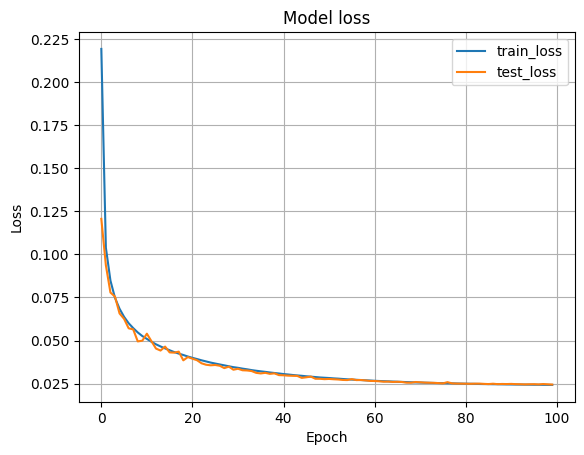

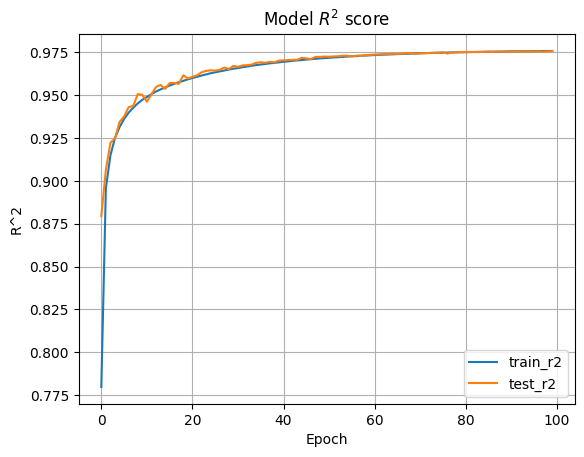

In [44]:
# Define the data
data = X_train
labels = y_train

# Convert the data to PyTorch tensors
data = torch.from_numpy(data).float()
labels = torch.from_numpy(labels).float()

# Define the data loader
trainset = torch.utils.data.TensorDataset(data, labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net_1m.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer,gamma=lr_decay_factor)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the neural network

epochs = 100

net_1m.to(device)
losses = []
r2s = []
test_losses = []
test_r2s = []
cur_lrs =[]
for epoch in range(epochs):
    net_1m.train()
    running_loss = 0.0
    running_r2 = 0.0
    for i, data in enumerate(trainloader, 0):
        
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net_1m(inputs)
        loss = criterion(outputs, labels)
        r2 = R2Loss()(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_r2 += r2.item()
    losses.append(running_loss / len(trainloader))
    r2s.append(running_r2 / len(trainloader))
#         print('Epoch %d loss: %.3f R^2: %.3f' % (epoch + 1, running_loss / len(trainloader), running_r2 / len(trainloader)))
    # Test the neural network on the test data
    test_data = X_test
    test_labels = y_test
    test_data = torch.from_numpy(test_data).float()
    test_labels = torch.from_numpy(test_labels).float()
    net_1m.eval()
    with torch.no_grad():
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        test_outputs = net_1m(test_data)
        test_loss = criterion(test_outputs, test_labels)
        test_r2 = R2Loss()(test_outputs, test_labels)
        test_losses.append(test_loss.item())
        test_r2s.append(test_r2.item())
    current_lr = optimizer.param_groups[0]['lr']
    cur_lrs.append(current_lr)
    print('Epoch %d loss: %.3f R^2: %.3f test_loss: %.3f test_R^2: %.3f  ' % (epoch + 1, running_loss / len(trainloader), running_r2 / len(trainloader), test_loss, test_r2))    
    scheduler.step()
    
# plotting model loss    
plt.plot(losses,label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend()
plt.grid()
plt.show()
# plotting model r2 score
plt.plot(r2s, label='train_r2')
plt.plot(test_r2s, label='test_r2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.title('Model $R^{2}$ score')
plt.legend()
plt.grid()
plt.show()

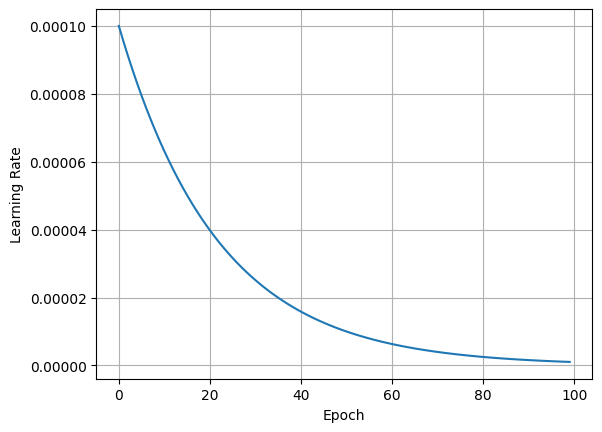

In [45]:
plt.plot( cur_lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid()
plt.show()

In [46]:
path = '/kaggle/working/lstm_1M_m_s_p'
torch.save(net_1m,path)

In [47]:
with torch.no_grad():
    test_data, test_labels = test_data.to(device), test_labels.to(device)
    test_outputs = net_1m(test_data)    
    pred = test_outputs
pred.shape

torch.Size([199195, 7])

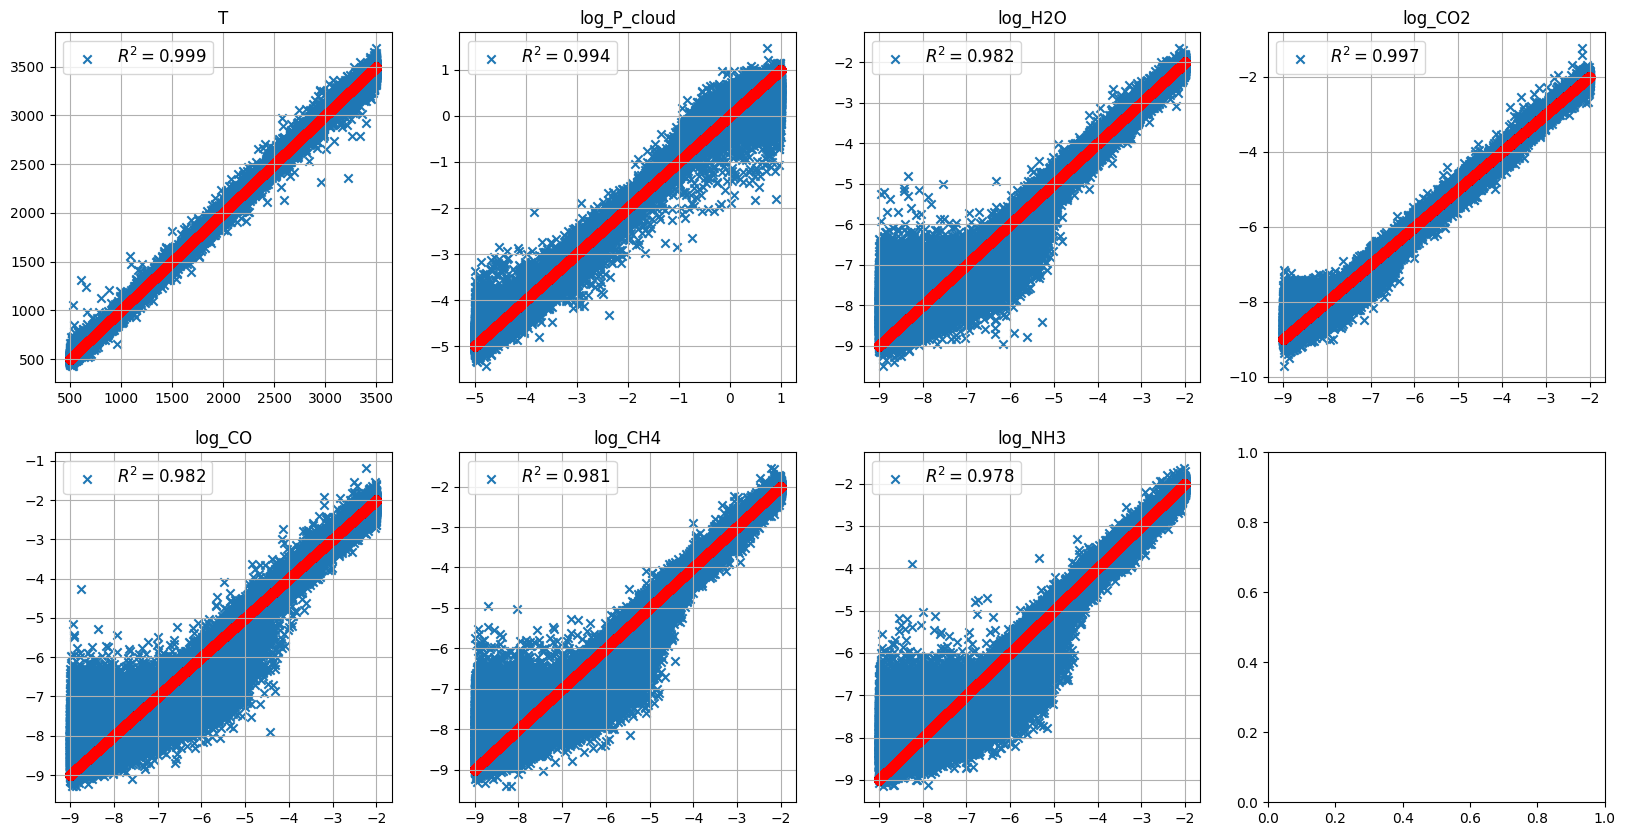

In [48]:
from scipy.stats import pearsonr

keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = np.array(pred.cpu())
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[0,i].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[1,i-4].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

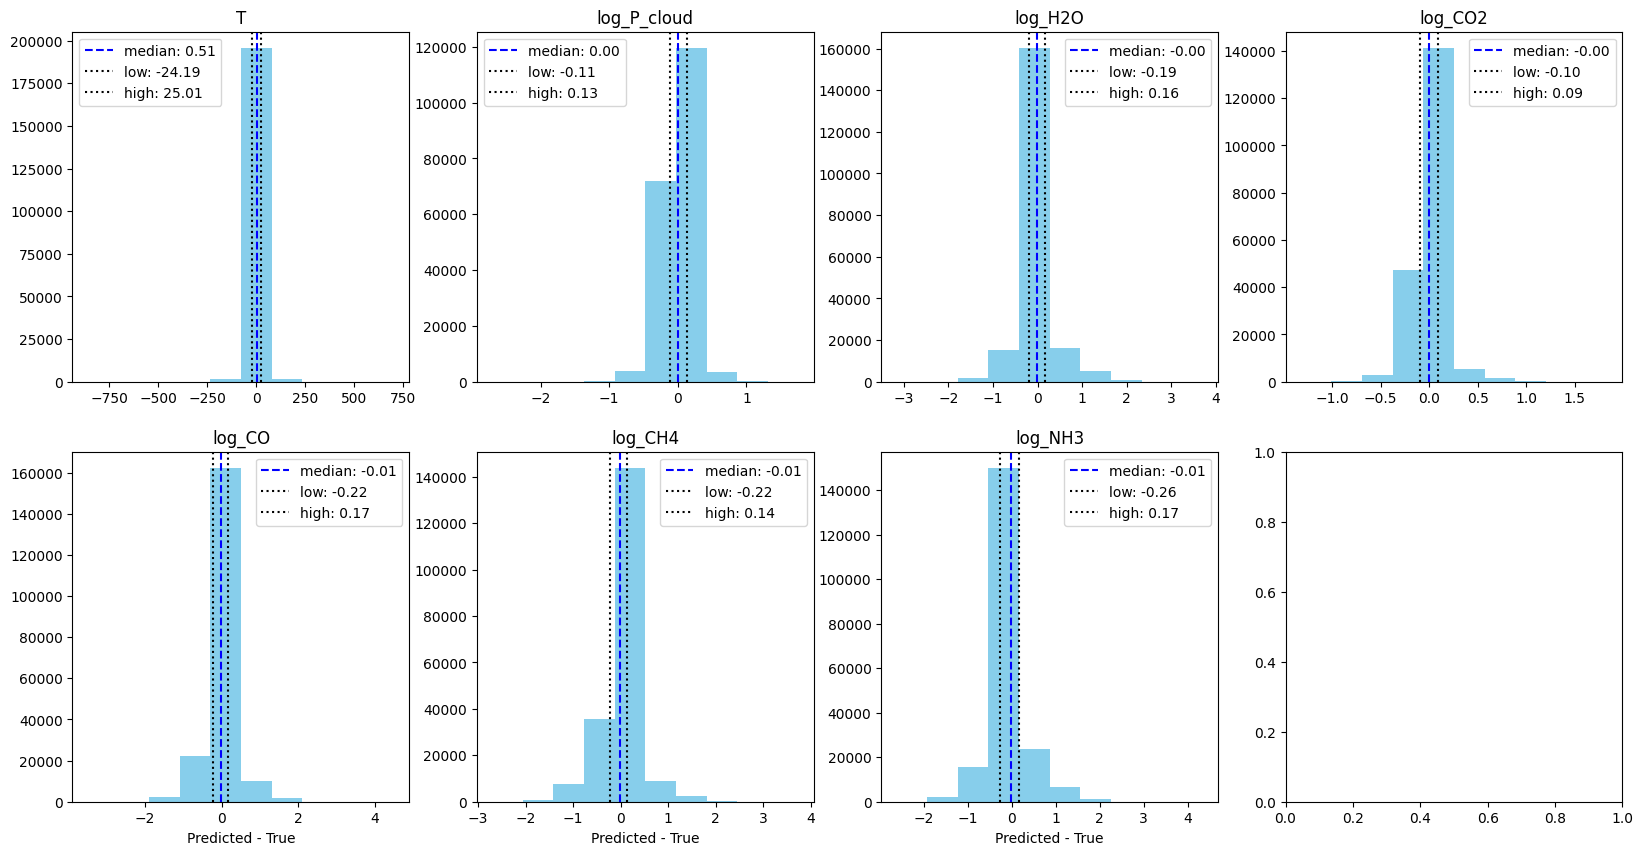

In [49]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = np.array(pred.cpu())
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[0,i].hist(pred_err,bins=10,color='skyblue')
        axs[0,i].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[0,i].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[0,i].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[1,i-4].hist(pred_err,bins=10,color='skyblue')
        axs[1,i-4].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[1,i-4].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[1,i-4].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')

In [50]:
y_test_rescaled_1M = scaler.inverse_transform(y_test)
predictions_1M = np.array(pred.cpu())
predictions_1M = scaler.inverse_transform(predictions_1M)

In [51]:
pred_data = torch.from_numpy(test_planets).float()
with torch.no_grad():
    pred_data = pred_data.to(device)
    pred = net_1m(pred_data)    
pred = np.array(pred.cpu())    
pred = scaler.inverse_transform(pred)
pred

array([[ 2.0607288e+03,  2.6529199e-01, -7.6471748e+00, -8.2352438e+00,
        -4.9395833e+00, -3.6677859e+00, -4.1999750e+00],
       [ 1.1580350e+03,  3.1096178e-01, -2.7903087e+00, -2.7708409e+00,
        -8.1420069e+00, -5.7686725e+00, -5.1168118e+00],
       [ 2.6084299e+03, -3.4738379e+00, -5.4169631e+00, -5.1656222e+00,
        -5.9500771e+00, -2.6761441e+00, -5.5462904e+00]], dtype=float32)

In [52]:
planetA_pred_1M = pred[0]
print("Predicted values:",planetA_pred_1M)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.0607288e+03  2.6529199e-01 -7.6471748e+00 -8.2352438e+00
 -4.9395833e+00 -3.6677859e+00 -4.1999750e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


In [53]:
planetB_pred_1M = pred[1]
print("Predicted values:",planetB_pred_1M)
print("Actual values:",planetB_params[3:])

Predicted values: [ 1.1580350e+03  3.1096178e-01 -2.7903087e+00 -2.7708409e+00
 -8.1420069e+00 -5.7686725e+00 -5.1168118e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


In [54]:
planetC_pred_1M = pred[2]
print("Predicted values:",planetC_pred_1M)
print("Actual values:",planetC_params[3:])

Predicted values: [2608.43        -3.4738379   -5.416963    -5.165622    -5.950077
   -2.6761441   -5.5462904]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


## Comparison

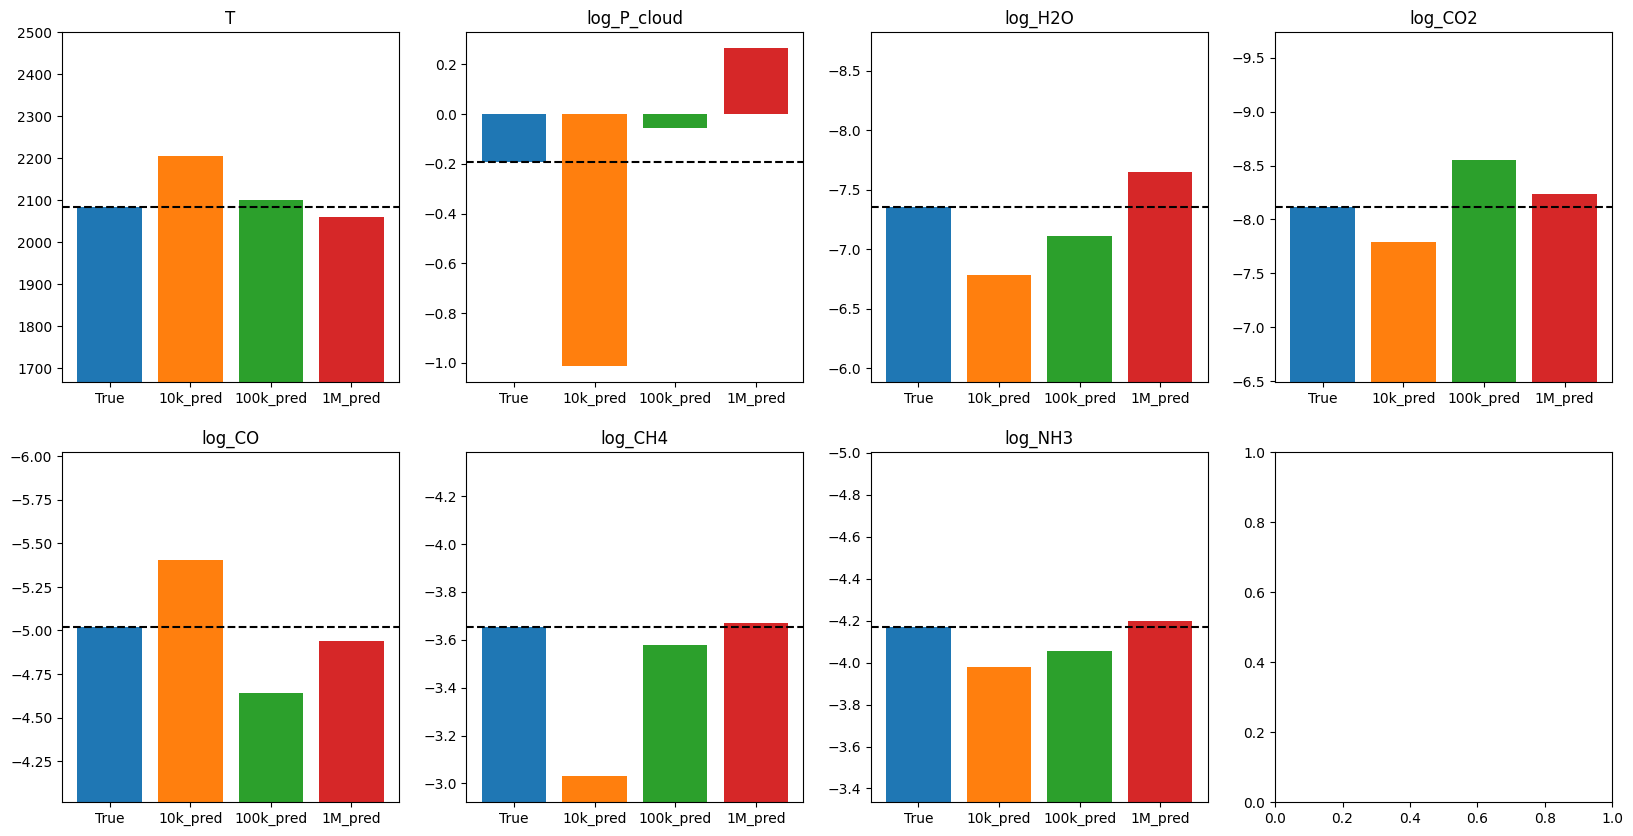

In [55]:
labels1 = ['True']
labels2 = ['10k_pred']
labels3 = ['100k_pred']
labels4 = ['1M_pred']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(7):
    if i < 2:
        axs[0,i].bar(labels1, planetA_params[3+i])
        axs[0,i].bar(labels2, planetA_pred_10k[i])
        axs[0,i].bar(labels3, planetA_pred_100k[i])
        axs[0,i].bar(labels4, planetA_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetA_params[3+i],color='black', linestyle='--')
        axs[0,0].set_ylim(0.80*planetA_params[3],1.20*planetA_params[3])
    elif i<4 and i>1:
        axs[0,i].bar(labels1, planetA_params[3+i])
        axs[0,i].bar(labels2, planetA_pred_10k[i])
        axs[0,i].bar(labels3, planetA_pred_100k[i])
        axs[0,i].bar(labels4, planetA_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetA_params[3+i],color='black', linestyle='--')
        axs[0,i].invert_yaxis()
        axs[0,i].set_ylim(0.80*planetA_params[3+i],1.20*planetA_params[3+i])
    else:
        axs[1,i-4].bar(labels1, planetA_params[3+i])
        axs[1,i-4].bar(labels2, planetA_pred_10k[i])
        axs[1,i-4].bar(labels3, planetA_pred_100k[i])
        axs[1,i-4].bar(labels4, planetA_pred_1M[i])
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].axhline(y=planetA_params[3+i],color='black', linestyle='--')
        axs[1,i-4].invert_yaxis()
        axs[1,i-4].set_ylim(0.80*planetA_params[3+i],1.20*planetA_params[3+i])
        
plt.savefig('comparison_plot1.png')

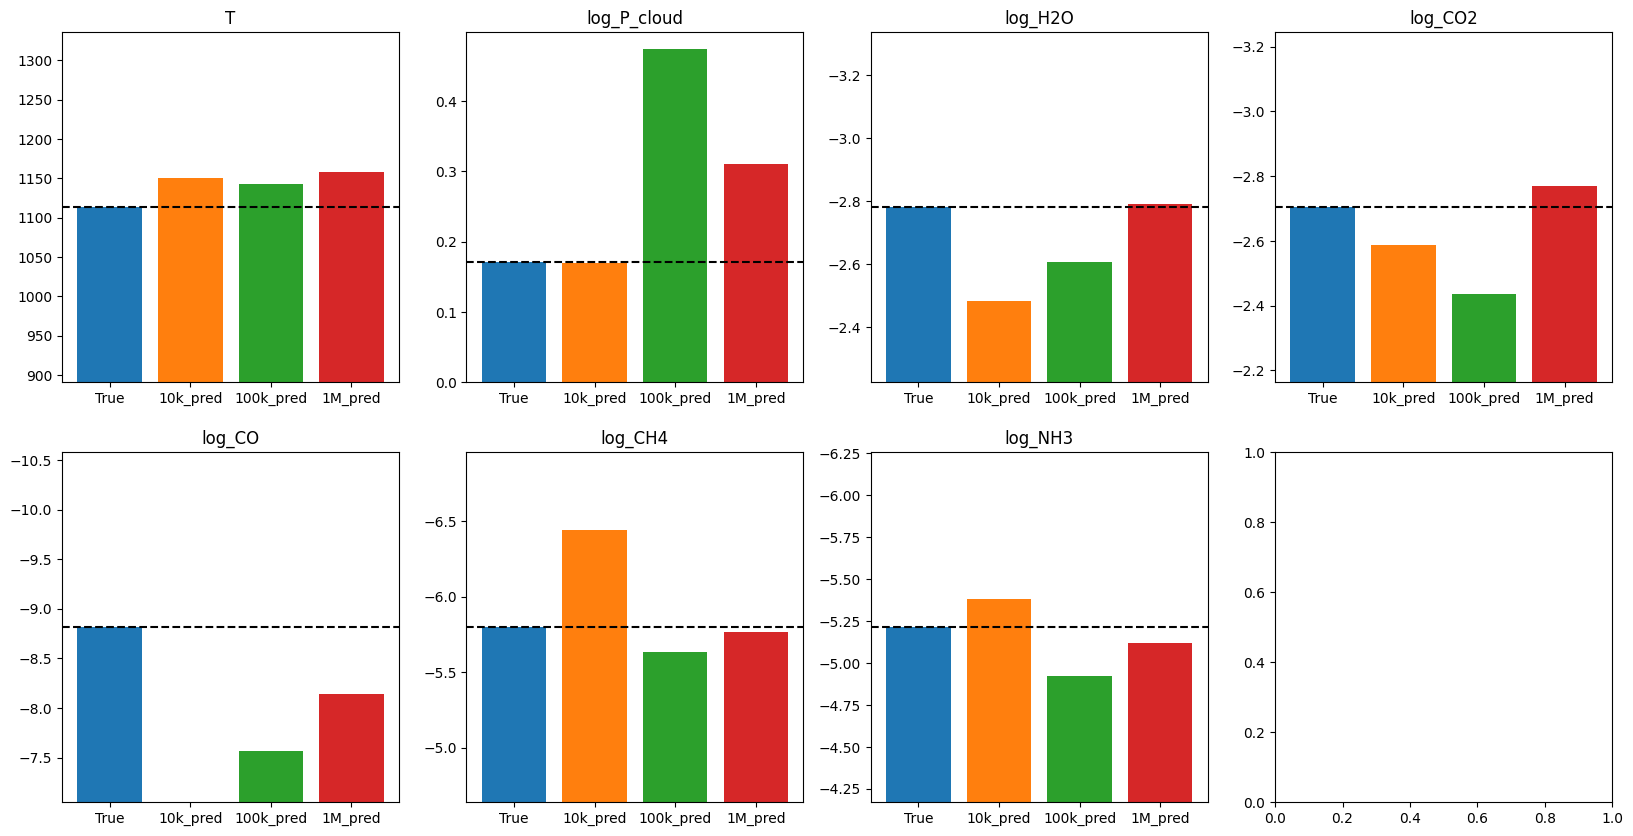

In [56]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(7):
    if i < 2:
        axs[0,i].bar(labels1, planetB_params[3+i])
        axs[0,i].bar(labels2, planetB_pred_10k[i])
        axs[0,i].bar(labels3, planetB_pred_100k[i])
        axs[0,i].bar(labels4, planetB_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetB_params[3+i],color='black', linestyle='--')
        axs[0,0].set_ylim(0.80*planetB_params[3],1.20*planetB_params[3])
    elif i<4 and i>1:
        axs[0,i].bar(labels1, planetB_params[3+i])
        axs[0,i].bar(labels2, planetB_pred_10k[i])
        axs[0,i].bar(labels3, planetB_pred_100k[i])
        axs[0,i].bar(labels4, planetB_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetB_params[3+i],color='black', linestyle='--')
        axs[0,i].invert_yaxis()
        axs[0,i].set_ylim(0.80*planetB_params[3+i],1.20*planetB_params[3+i])
    else:
        axs[1,i-4].bar(labels1, planetB_params[3+i])
        axs[1,i-4].bar(labels2, planetB_pred_10k[i])
        axs[1,i-4].bar(labels3, planetB_pred_100k[i])
        axs[1,i-4].bar(labels4, planetB_pred_1M[i])
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].axhline(y=planetB_params[3+i],color='black', linestyle='--')
        axs[1,i-4].invert_yaxis()
        axs[1,i-4].set_ylim(0.80*planetB_params[3+i],1.20*planetB_params[3+i])
        
plt.savefig('comparison_plot2.png')

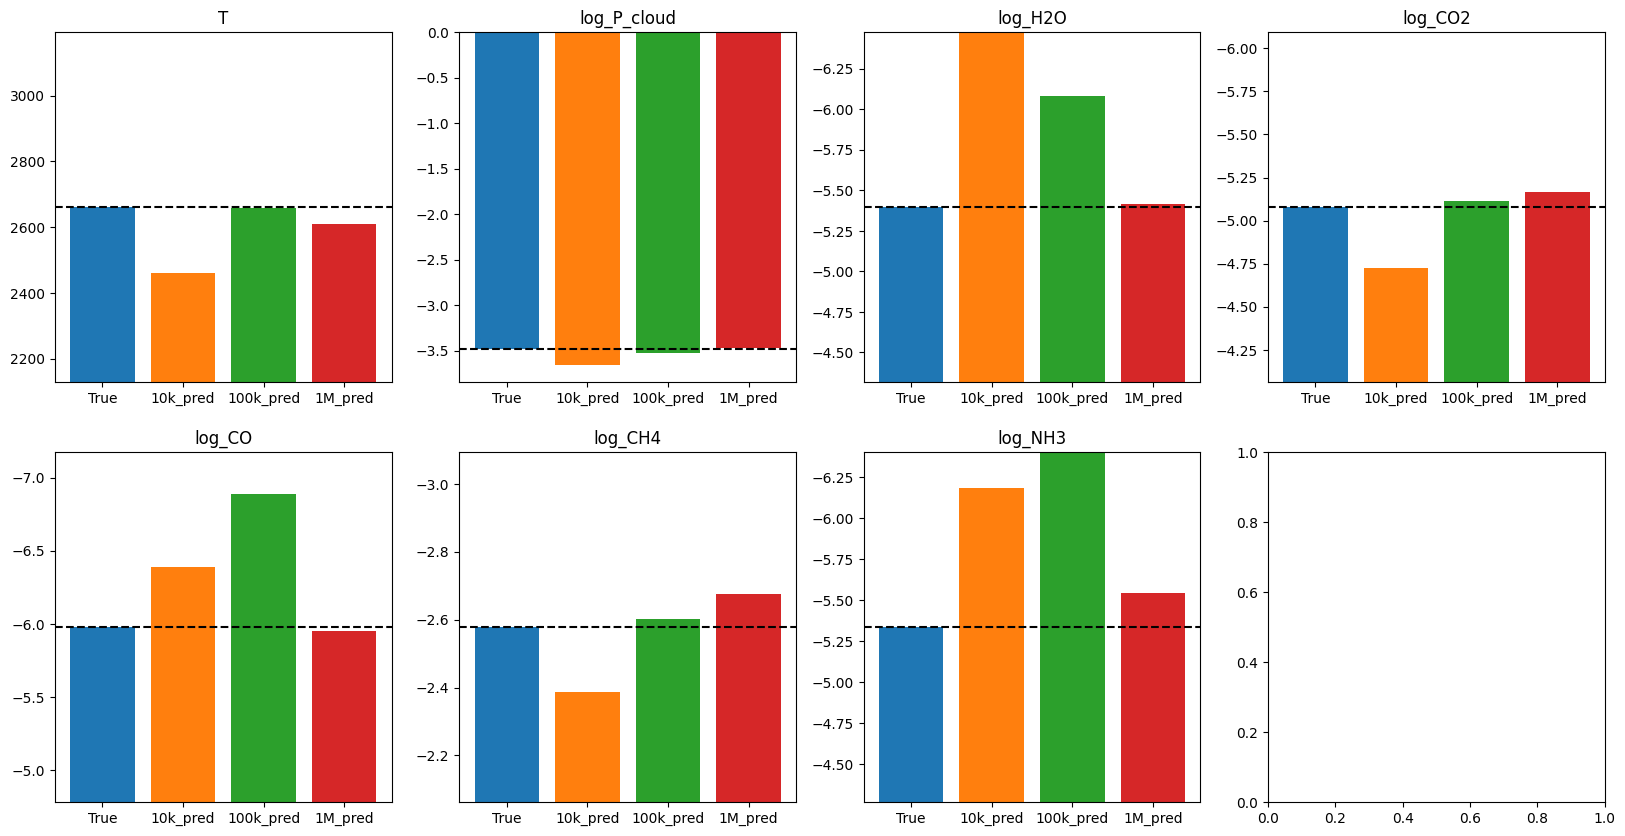

In [57]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(7):
    if i < 2:
        axs[0,i].bar(labels1, planetC_params[3+i])
        axs[0,i].bar(labels2, planetC_pred_10k[i])
        axs[0,i].bar(labels3, planetC_pred_100k[i])
        axs[0,i].bar(labels4, planetC_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetC_params[3+i],color='black', linestyle='--')
        axs[0,0].set_ylim(0.80*planetC_params[3],1.20*planetC_params[3])
    elif i<4 and i>1:
        axs[0,i].bar(labels1, planetC_params[3+i])
        axs[0,i].bar(labels2, planetC_pred_10k[i])
        axs[0,i].bar(labels3, planetC_pred_100k[i])
        axs[0,i].bar(labels4, planetC_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetC_params[3+i],color='black', linestyle='--')
        axs[0,i].invert_yaxis()
        axs[0,i].set_ylim(0.80*planetC_params[3+i],1.20*planetC_params[3+i])
    else:
        axs[1,i-4].bar(labels1, planetC_params[3+i])
        axs[1,i-4].bar(labels2, planetC_pred_10k[i])
        axs[1,i-4].bar(labels3, planetC_pred_100k[i])
        axs[1,i-4].bar(labels4, planetC_pred_1M[i])
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].axhline(y=planetC_params[3+i],color='black', linestyle='--')
        axs[1,i-4].invert_yaxis()
        axs[1,i-4].set_ylim(0.80*planetC_params[3+i],1.20*planetC_params[3+i])
        
plt.savefig('comparison_plot3.png')

## Error histograms

In [58]:
y_test_rescaled_10k.shape, predictions_10k.shape

((2000, 7), (2000, 7))

In [59]:
y_test_rescaled_100k.shape, predictions_100k.shape

((20000, 7), (20000, 7))

In [60]:
y_test_rescaled_1M.shape, predictions_1M.shape

((199195, 7), (199195, 7))

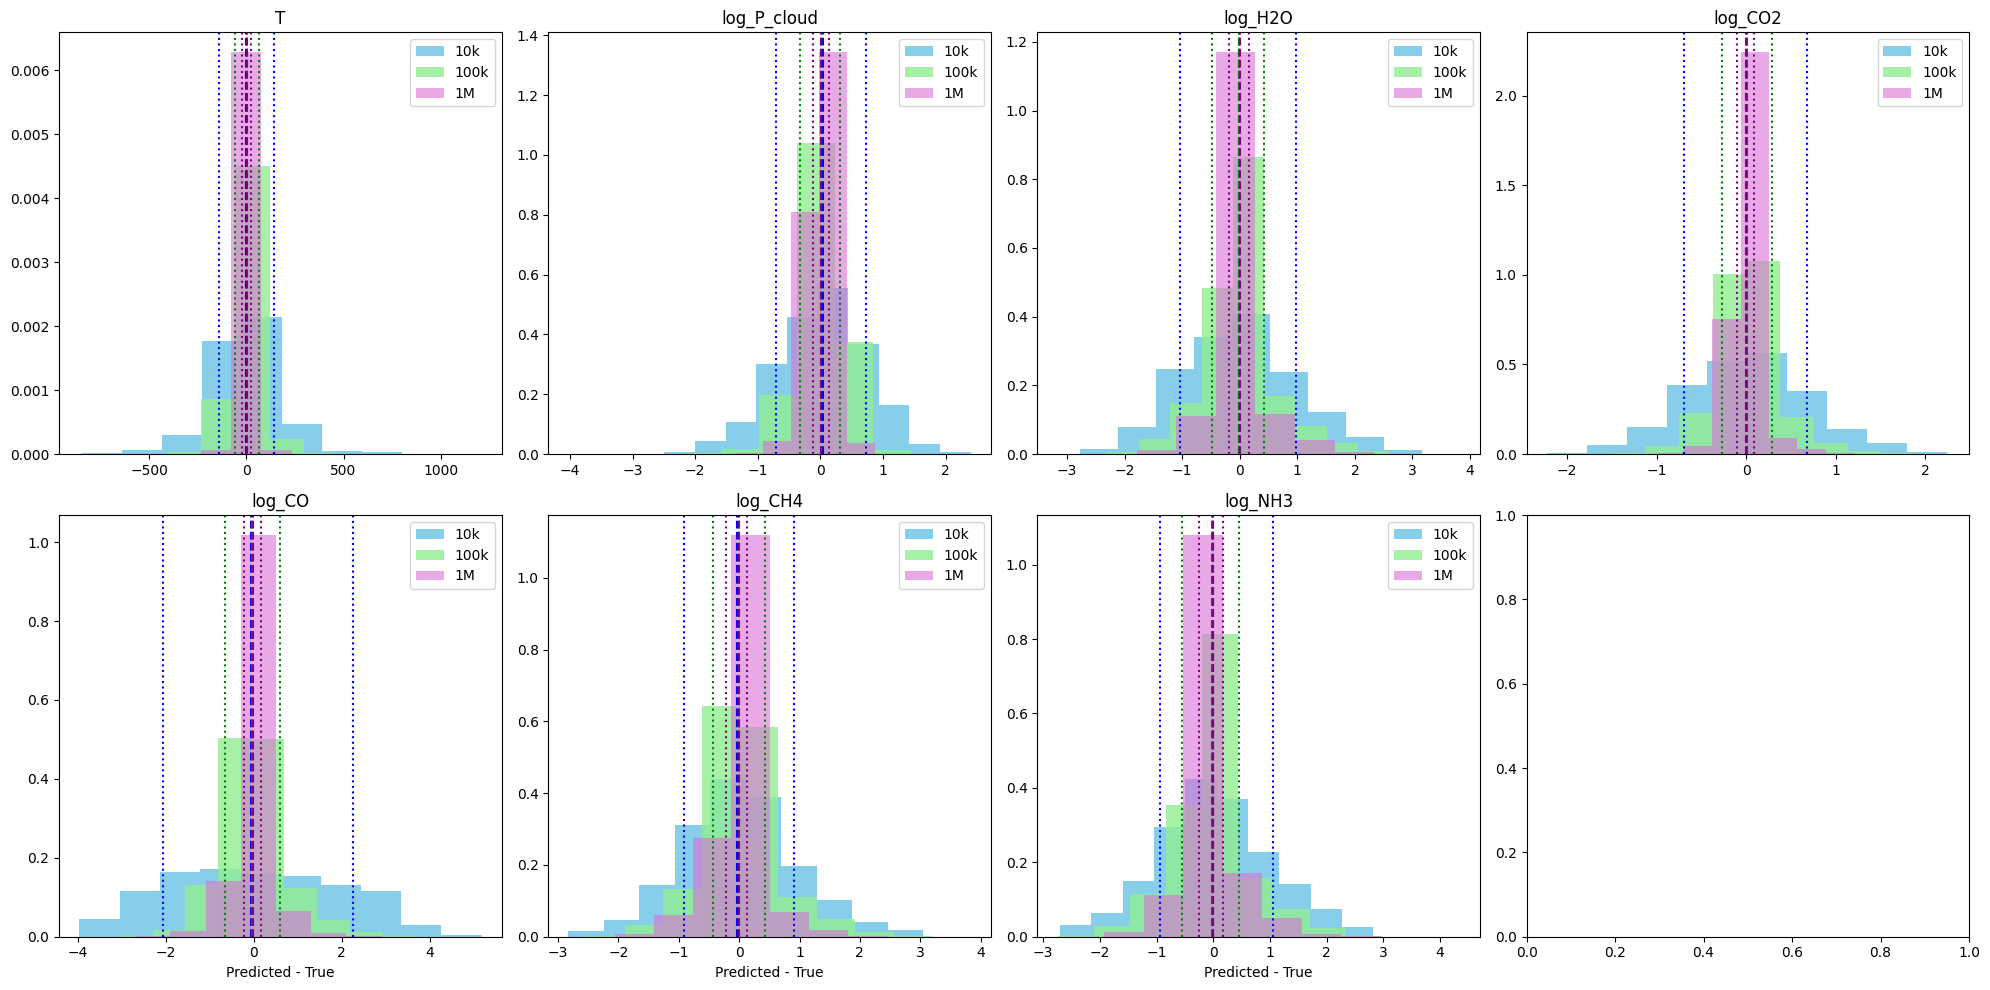

In [61]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(7):
    if i < 4:
        pred_err_10k = predictions_10k[:,i]-y_test_rescaled_10k[:,i]
        pred_err_100k = predictions_100k[:,i]-y_test_rescaled_100k[:,i]
        pred_err_1M = predictions_1M[:,i]-y_test_rescaled_1M[:,i]
        low_10k, med_10k, high_10k = np.percentile(pred_err_10k,(15.9,50,84.1))
        low_100k, med_100k, high_100k = np.percentile(pred_err_100k,(15.9,50,84.1))
        low_1M, med_1M, high_1M = np.percentile(pred_err_1M,(15.9,50,84.1))
        
        axs[0,i].hist(pred_err_10k,bins=10,color='skyblue',label='10k',density=True)
        axs[0,i].axvline(x=med_10k,color='blue',linestyle='--')
        axs[0,i].axvline(x=low_10k,color='blue',linestyle=':')
        axs[0,i].axvline(x=high_10k,color='blue',linestyle=':')

        axs[0,i].hist(pred_err_100k,bins=10,color='lightgreen',label='100k',density=True,alpha=0.8)
        axs[0,i].axvline(x=med_100k,color='green',linestyle='--')
        axs[0,i].axvline(x=low_100k,color='green',linestyle=':')
        axs[0,i].axvline(x=high_100k,color='green',linestyle=':')

        axs[0,i].hist(pred_err_1M,bins=10,color='orchid',label='1M',density=True,alpha=0.6)
        axs[0,i].axvline(x=med_1M,color='purple',linestyle='--')
        axs[0,i].axvline(x=low_1M,color='purple',linestyle=':')
        axs[0,i].axvline(x=high_1M,color='purple',linestyle=':')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err_10k = predictions_10k[:,i]-y_test_rescaled_10k[:,i]
        pred_err_100k = predictions_100k[:,i]-y_test_rescaled_100k[:,i]
        pred_err_1M = predictions_1M[:,i]-y_test_rescaled_1M[:,i]
        low_10k, med_10k, high_10k = np.percentile(pred_err_10k,(15.9,50,84.1))
        low_100k, med_100k, high_100k = np.percentile(pred_err_100k,(15.9,50,84.1))
        low_1M, med_1M, high_1M = np.percentile(pred_err_1M,(15.9,50,84.1))
        
        axs[1,i-4].hist(pred_err_10k,bins=10,color='skyblue',label='10k',density=True)
        axs[1,i-4].axvline(x=med_10k,color='blue',linestyle='--')
        axs[1,i-4].axvline(x=low_10k,color='blue',linestyle=':')
        axs[1,i-4].axvline(x=high_10k,color='blue',linestyle=':')

        axs[1,i-4].hist(pred_err_100k,bins=10,color='lightgreen',label='100k',density=True,alpha=0.8)
        axs[1,i-4].axvline(x=med_100k,color='green',linestyle='--')
        axs[1,i-4].axvline(x=low_100k,color='green',linestyle=':')
        axs[1,i-4].axvline(x=high_100k,color='green',linestyle=':')

        axs[1,i-4].hist(pred_err_1M,bins=10,color='orchid',label='1M',density=True,alpha=0.6)
        axs[1,i-4].axvline(x=med_1M,color='purple',linestyle='--')
        axs[1,i-4].axvline(x=low_1M,color='purple',linestyle=':')
        axs[1,i-4].axvline(x=high_1M,color='purple',linestyle=':')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')
plt.tight_layout()
plt.savefig('error_histograms1.png')

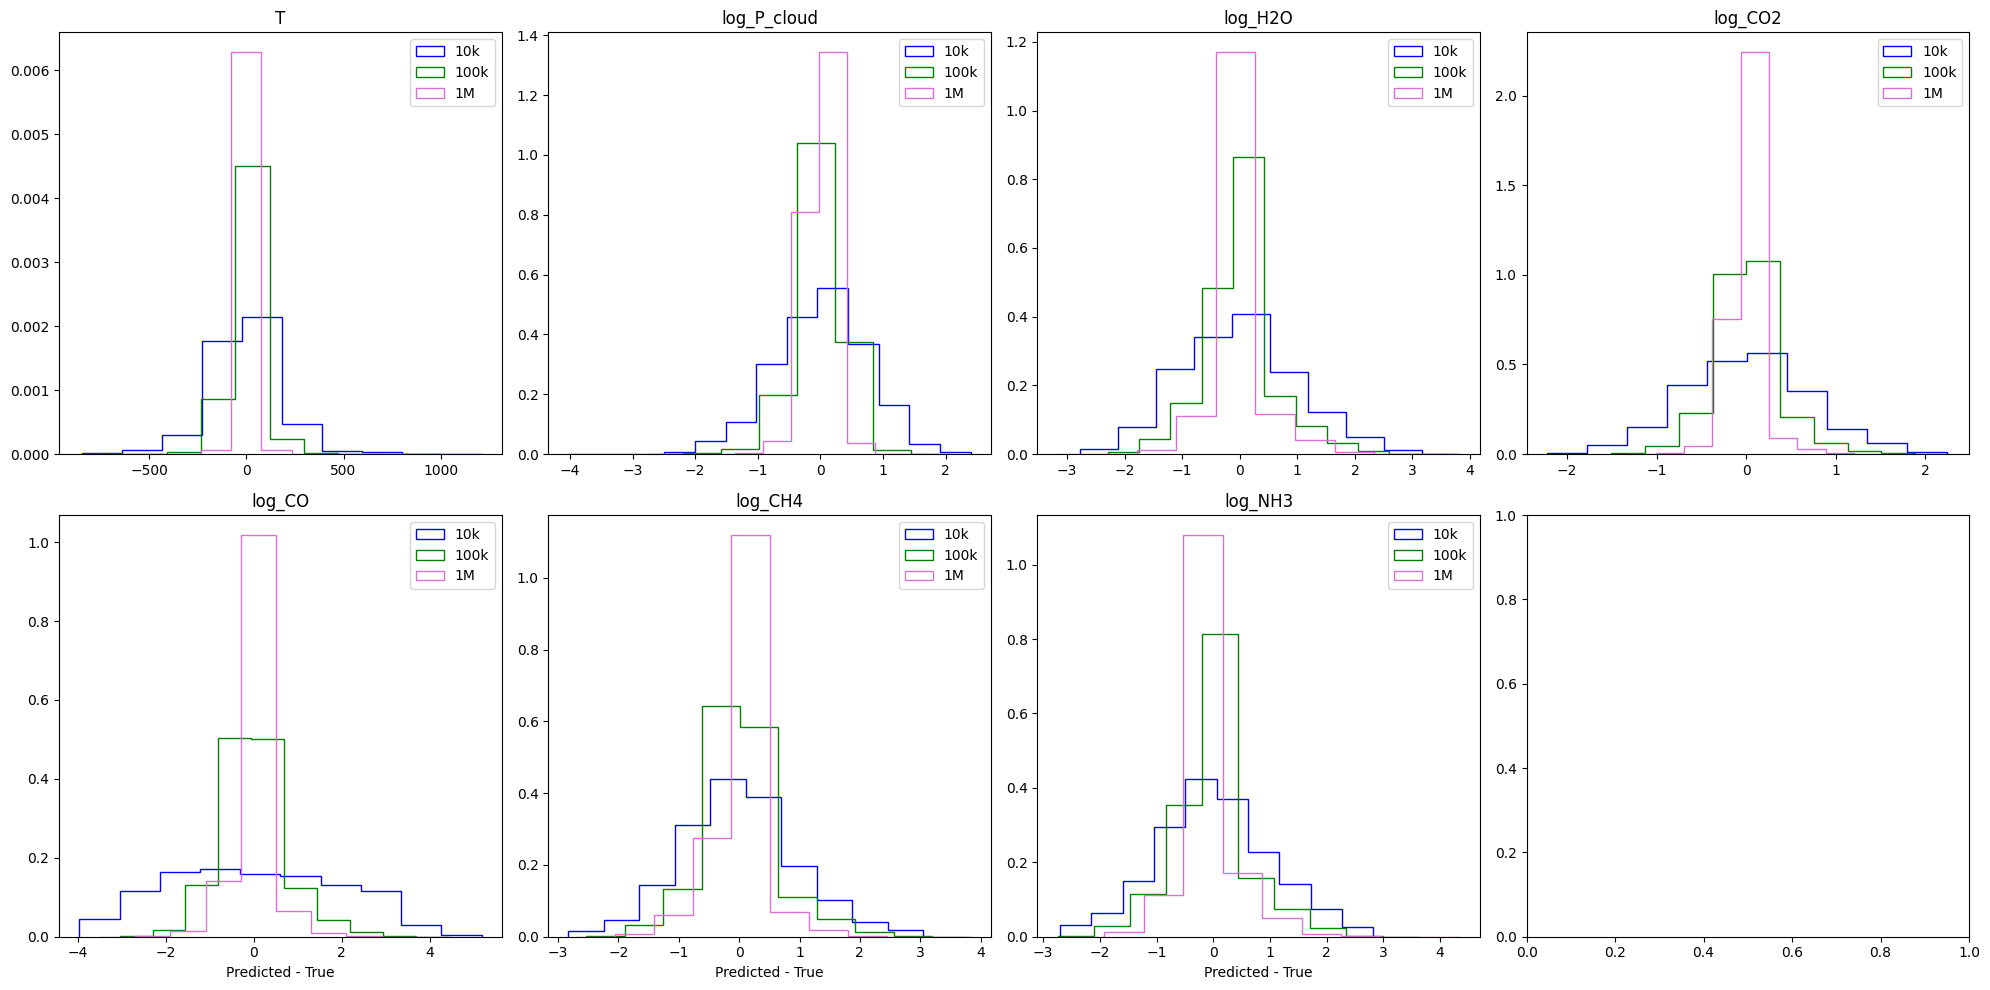

In [62]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(7):
    if i < 4:
        pred_err_10k = predictions_10k[:,i]-y_test_rescaled_10k[:,i]
        pred_err_100k = predictions_100k[:,i]-y_test_rescaled_100k[:,i]
        pred_err_1M = predictions_1M[:,i]-y_test_rescaled_1M[:,i]
        low_10k, med_10k, high_10k = np.percentile(pred_err_10k,(15.9,50,84.1))
        low_100k, med_100k, high_100k = np.percentile(pred_err_100k,(15.9,50,84.1))
        low_1M, med_1M, high_1M = np.percentile(pred_err_1M,(15.9,50,84.1))
        
        axs[0,i].hist(pred_err_10k,bins=10,color='blue',label='10k',density=True,histtype='step')
    
        axs[0,i].hist(pred_err_100k,bins=10,color='green',label='100k',density=True,histtype='step')
        

        axs[0,i].hist(pred_err_1M,bins=10,color='orchid',label='1M',density=True,histtype='step')

        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err_10k = predictions_10k[:,i]-y_test_rescaled_10k[:,i]
        pred_err_100k = predictions_100k[:,i]-y_test_rescaled_100k[:,i]
        pred_err_1M = predictions_1M[:,i]-y_test_rescaled_1M[:,i]
        low_10k, med_10k, high_10k = np.percentile(pred_err_10k,(15.9,50,84.1))
        low_100k, med_100k, high_100k = np.percentile(pred_err_100k,(15.9,50,84.1))
        low_1M, med_1M, high_1M = np.percentile(pred_err_1M,(15.9,50,84.1))
        
        axs[1,i-4].hist(pred_err_10k,bins=10,color='blue',label='10k',density=True,histtype='step')


        axs[1,i-4].hist(pred_err_100k,bins=10,color='green',label='100k',density=True,histtype='step')


        axs[1,i-4].hist(pred_err_1M,bins=10,color='orchid',label='1M',density=True,histtype='step')

        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')
plt.tight_layout()
plt.savefig('error_histograms2.png')